## 2025년 9월 기준 평균 매매 가격 구별 순위 (부동산 지인)

![](202509%20평균%20매매%20가격%20구별%20순위(부동산%20지인).png)

강남구
서초구
- - -
용산구
송파구
- - -
성동구
양천구
광진구
마포구
- - -
강동구
영등포구
동장구
중구
종로구
- - -
서대문구
강서구
동대문구
- - -
성북구
은평구
관악구
노원구
구로구
중랑구
강북구
금천구
도봉구

** 강남구를 먼저 분석해보자 **

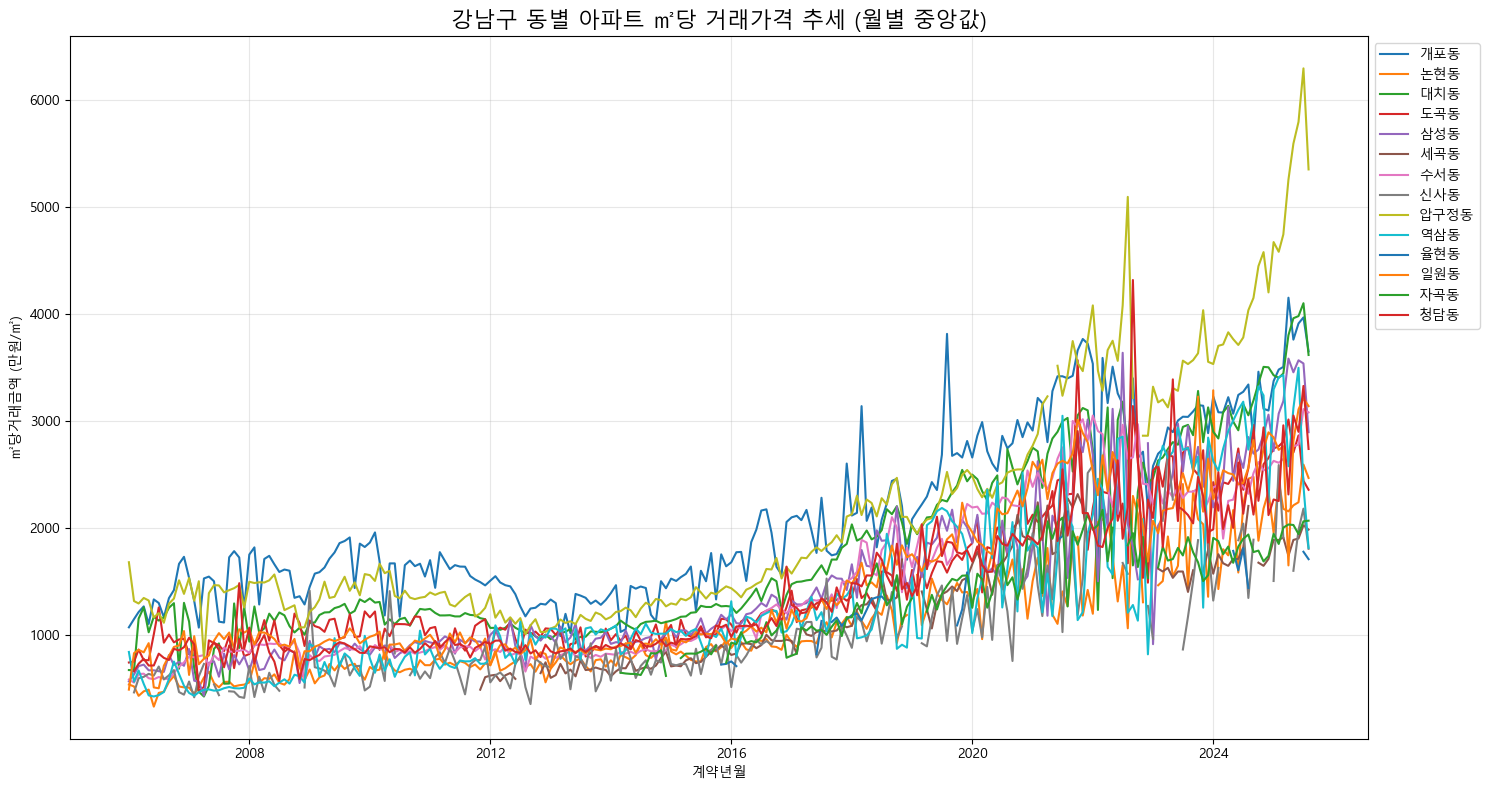

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import mpld3 

# 한글 폰트 적용
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

# === 0) 데이터 로드 ===
# utf-8-sig로 BOM 이슈 회피, thousands=','로 콤마 숫자 자동 파싱도 시도
df = pd.read_csv("gangnam.csv", encoding="utf-8-sig")

# === 1) 강남구만 필터 ===
# df = df[df["시군구"].str.contains("강남구", na=False)].copy()

# === 2) '동' 추출 (예: "서울특별시 강남구 개포동" -> "개포동")
# '... 강남구 ' 다음에 오는 '...동' 토큰을 캡처
df["동"] = df["시군구"].str.extract(r"강남구\s*([가-힣0-9]+동)")

# # 분석할 동 리스트
# target_dongs = ["압구정동", "청담동", "개포동", "대치동", "삼성동"]
# df = df[df["동"].isin(target_dongs)]

# === 3) 숫자 컬럼 정규화 ===
# 천 단위 콤마/공백/문자 제거 후 numeric 변환
def to_num(s):
    return pd.to_numeric(
        pd.Series(s, dtype="string").str.replace(r"[^\d\.\-]", "", regex=True),
        errors="coerce"
    )

df["전용면적(㎡)"]   = to_num(df["전용면적(㎡)"])
df["거래금액(만원)"] = to_num(df["거래금액(만원)"])
df["층"]           = to_num(df["층"])
df["건축년도"]     = to_num(df["건축년도"])

# 면적/가격 결측치 제거 (㎡당가격 계산을 위해 필수)
df = df.dropna(subset=["전용면적(㎡)", "거래금액(만원)", "동"])

# === 4) ㎡당 가격 생성 (만원/㎡) ===
df["㎡당거래금액"] = df["거래금액(만원)"] / df["전용면적(㎡)"]

# === 5) '계약년월'(yyyymm) -> 월(datetime) 변환 ===
# 문자열로 캐스팅 후 yyyymm 파싱
df["계약년월"] = pd.to_datetime(df["계약년월"].astype("string"), format="%Y%m", errors="coerce")

# 분석 기간 필터 (2006-01 ~ 2025-08)
df = df[(df["계약년월"] >= "2006-01-01") & (df["계약년월"] <= "2025-08-31")]

# === 6) 동별 · 월별 중앙값 집계 ===
df_grouped = (
    df.groupby(["동", "계약년월"])["㎡당거래금액"]
      .median()
      .reset_index()
)

# === 7) 피벗 & 시각화 ===
df_pivot = df_grouped.pivot(index="계약년월", columns="동", values="㎡당거래금액").sort_index()

plt.figure(figsize=(15, 8))
for dong in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[dong], label=dong)

plt.title("강남구 동별 아파트 ㎡당 거래가격 추세 (월별 중앙값)", fontsize=16)
plt.xlabel("계약년월")
plt.ylabel("㎡당거래금액 (만원/㎡)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()

# mpld3.save_html(plt.gcf(), "강남구 동별 아파트 m2당 거래가격 추세 (월별 중앙값).html")
# print("그래프가 html 파일로 성공적으로 저장되었습니다.")

plt.show()


** 압구정동이 가장 최근에 근 상승세를 보였다. 압구정동을 좀 더 파보자 **

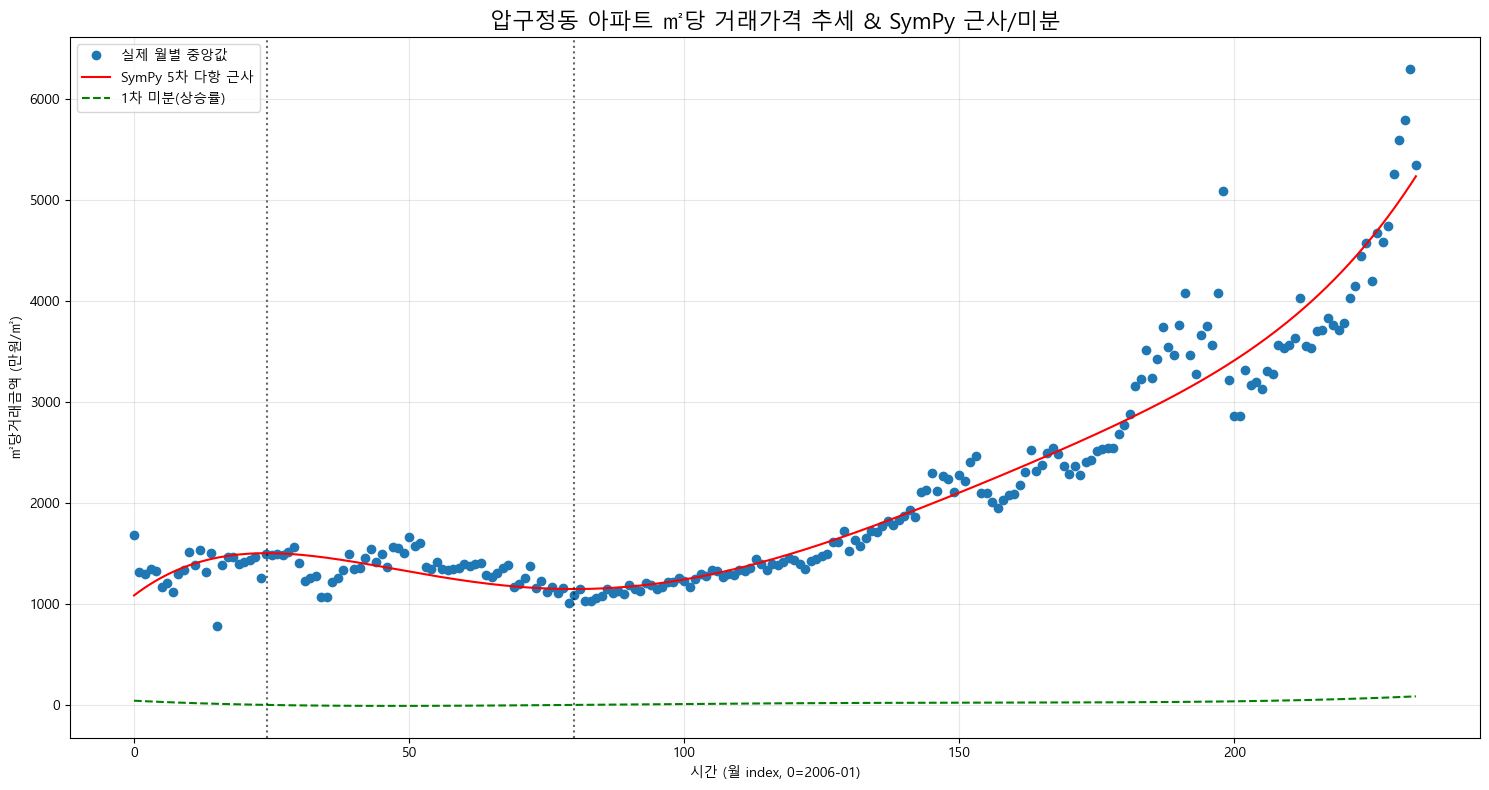

In [2]:
import pandas as pd
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 한글 폰트 적용
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

# ===== 1. 데이터 준비 =====
df = pd.read_csv("gangnam.csv", encoding="utf-8-sig")
df = df[df["시군구"].str.contains("강남구", na=False)].copy()
df["동"] = df["시군구"].str.extract(r"강남구\s*([가-힣0-9]+동)")

# 숫자 처리 함수
def to_num(s):
    return pd.to_numeric(
        pd.Series(s, dtype="string").str.replace(r"[^\d\.\-]", "", regex=True),
        errors="coerce"
    )

df["전용면적(㎡)"]   = to_num(df["전용면적(㎡)"])
df["거래금액(만원)"] = to_num(df["거래금액(만원)"])
df["㎡당거래금액"] = df["거래금액(만원)"] / df["전용면적(㎡)"]
df["계약년월"] = pd.to_datetime(df["계약년월"].astype(str), format="%Y%m", errors="coerce")

# 특정 동 선택 (예: 압구정동)
dong = "압구정동"
df_dong = (
    df[df["동"] == dong]
    .groupby("계약년월")["㎡당거래금액"]
    .median()
    .reset_index()
    .dropna()
)

# ===== 2. 시간축 숫자화 =====
df_dong = df_dong.sort_values("계약년월")
df_dong["t"] = np.arange(len(df_dong))   # 0,1,2,... 월 단위 인덱스

t_data = df_dong["t"].to_numpy()
y_data = df_dong["㎡당거래금액"].to_numpy()

# ===== 3. SymPy 다항식 근사 =====
t = sp.symbols("t")
degree = 5  # 다항식 차수 (3~7 정도 추천)
coeffs = sp.symbols(f"a0:{degree+1}")
f = sum(coeffs[i] * t**i for i in range(degree+1))

# 최소자승법으로 계수 추정
A = sp.Matrix([[ti**i for i in range(degree+1)] for ti in t_data])
y_vec = sp.Matrix(y_data)
c_hat = (A.T * A).LUsolve(A.T * y_vec)  # 계수 추정값

f_hat = f.subs(dict(zip(coeffs, c_hat)))
f_prime = sp.diff(f_hat, t)   # 1차 미분
f_double = sp.diff(f_hat, t, 2)  # 2차 미분

# ===== 4. 전환점 찾기 =====
crit_points = sp.nroots(f_prime)  # f'(t)=0 해
crit_real = [float(cp) for cp in crit_points if abs(sp.im(cp)) < 1e-6]

# ===== 5. 시각화 =====
f_func = sp.lambdify(t, f_hat, "numpy")
dfunc = sp.lambdify(t, f_prime, "numpy")

T = np.linspace(t_data.min(), t_data.max(), 500)

plt.figure(figsize=(15, 8))
plt.plot(df_dong["t"], y_data, "o", label="실제 월별 중앙값")
plt.plot(T, f_func(T), "r-", label=f"SymPy {degree}차 다항 근사")
plt.plot(T, dfunc(T), "g--", label="1차 미분(상승률)")

# 극값 후보 표시
for cp in crit_real:
    if t_data.min() <= cp <= t_data.max():
        plt.axvline(cp, color="k", linestyle=":", alpha=0.6)

plt.title(f"{dong} 아파트 ㎡당 거래가격 추세 & SymPy 근사/미분", fontsize=16)
plt.xlabel("시간 (월 index, 0=2006-01)")
plt.ylabel("㎡당거래금액 (만원/㎡)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
